<a href="https://colab.research.google.com/github/rajlm10/Diffusion/blob/main/Diffusers_Intro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%pip install -qq -U diffusers datasets transformers accelerate ftfy pyarrow

     |████████████████████████████████| 524 kB 14.8 MB/s 
     |████████████████████████████████| 452 kB 66.0 MB/s 
     |████████████████████████████████| 5.8 MB 61.5 MB/s 
     |████████████████████████████████| 191 kB 52.5 MB/s 
     |████████████████████████████████| 53 kB 2.3 MB/s 
     |████████████████████████████████| 36.0 MB 42 kB/s 
     |████████████████████████████████| 182 kB 62.9 MB/s 
     |████████████████████████████████| 212 kB 54.9 MB/s 
     |████████████████████████████████| 132 kB 100.8 MB/s 
     |████████████████████████████████| 127 kB 78.0 MB/s 
     |████████████████████████████████| 7.6 MB 73.5 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pandas-gbq 0.17.9 requires pyarrow<10.0dev,>=3.0.0, but you have pyarrow 10.0.1 which is incompatible.


In [ ]:
import numpy as np
import torch
import torch.nn.functional as F
from matplotlib import pyplot as plt
import torchvision
from PIL import Image
from datasets import load_dataset
import pandas as pd
from torchvision import transforms
from diffusers import DDPMScheduler, UNet2DModel,DDPMPipeline


In [ ]:
pd.options.plotting.backend = "plotly"

#Utils

In [ ]:
def show_images(x):
    """Given a batch of images x, make a grid and convert to PIL"""
    x = x * 0.5 + 0.5  # Map from (-1, 1) back to (0, 1)
    grid = torchvision.utils.make_grid(x)
    grid_im = grid.detach().cpu().permute(1, 2, 0).clip(0, 1) * 255
    grid_im = Image.fromarray(np.array(grid_im).astype(np.uint8))
    return grid_im

def make_grid(images, size=64):
    """Given a list of PIL images, stack them together into a line for easy viewing"""
    output_im = Image.new("RGB", (size * len(images), size))
    for i, im in enumerate(images):
        output_im.paste(im.resize((size, size)), (i * size, 0))
    return output_im


# Mac users may need device = 'mps' (untested)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#Pipeline

Downloading:   0%|          | 0.00/180 [00:00<?, ?B/s]

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

Downloading:   0%|          | 0.00/702 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/74.3M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/267 [00:00<?, ?B/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

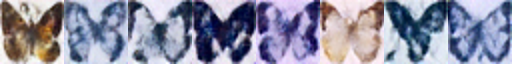

In [ ]:
from diffusers import DDPMPipeline

# Load the butterfly pipeline
butterfly_pipeline = DDPMPipeline.from_pretrained(
    "johnowhitaker/ddpm-butterflies-32px"
).to(device)

# Create 8 images
images = butterfly_pipeline(batch_size=8).images

# View the result
make_grid(images)

#Training

1.   Load in some images from the training data
2.   Add noise, in different amounts. 
3.   Feed the noisy versions of the inputs into the model
4.   Evaluate how well the model does at denoising these inputs
5.   Use this information to update the model weights, and repeat

##Dataloader

In [ ]:
dataset = load_dataset("lambdalabs/pokemon-blip-captions", split="train")


In [ ]:
# We'll train on 128-pixel square images, but you can try larger sizes too
image_size = 128
# You can lower your batch size if you're running out of GPU memory
batch_size = 8

# Define data augmentations
preprocess = transforms.Compose(
    [
        transforms.Resize((image_size, image_size)),  # Resize
        transforms.RandomHorizontalFlip(),  # Randomly flip (data augmentation)
        transforms.ToTensor(),  # Convert to tensor (0, 1)
        transforms.Normalize([0.5], [0.5]),  # Map to (-1, 1)
    ]
)


def transform(examples):
    images = [preprocess(image.convert("RGB")) for image in examples["image"]]
    return {"images": images}


dataset.set_transform(transform)

# Create a dataloader from the dataset to serve up the transformed images in batches
train_dataloader = torch.utils.data.DataLoader(
    dataset, batch_size=batch_size, shuffle=True
)

In [ ]:
x = next(iter(train_dataloader))["images"].to(device)[:8]
x.shape

torch.Size([8, 3, 128, 128])

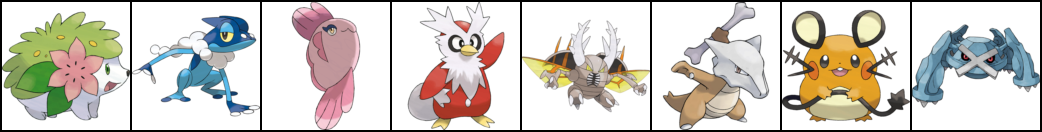

In [ ]:
show_images(x)

##Scheduler

The DDPM paper describes a corruption process that adds a small amount of noise for every 'timestep'. Given $x_{t-1}$ for some timestep, we can get the next (slightly more noisy) version $x_t$ with:<br><br>

$q(\mathbf{x}_t \vert \mathbf{x}_{t-1}) = \mathcal{N}(\mathbf{x}_t; \sqrt{1 - \beta_t} \mathbf{x}_{t-1}, \beta_t\mathbf{I}) \quad
q(\mathbf{x}_{1:T} \vert \mathbf{x}_0) = \prod^T_{t=1} q(\mathbf{x}_t \vert \mathbf{x}_{t-1})$<br><br>


That is, we take $x_{t-1}$, scale it by $\sqrt{1 - \beta_t}$ and add noise scaled by $\beta_t$. This $\beta$ is defined for every t according to some schedule, and determines how much noise is added per timestep. Now, we don't necessarily want to do this operation 500 times to get $x_{500}$ so we have another formula to get $x_t$ for any t given $x_0$: <br><br>

$\begin{aligned}
q(\mathbf{x}_t \vert \mathbf{x}_0) &= \mathcal{N}(\mathbf{x}_t; \sqrt{\bar{\alpha}_t} \mathbf{x}_0, {(1 - \bar{\alpha}_t)} \mathbf{I})
\end{aligned}$ where $\bar{\alpha}_t = \prod_{i=1}^T \alpha_i$ and $\alpha_i = 1-\beta_i$<br><br>

The maths notation always looks scary! Luckily the scheduler handles all that for us. We can plot $\sqrt{\bar{\alpha}_t}$ (labelled as `sqrt_alpha_prod`) and $\sqrt{(1 - \bar{\alpha}_t)}$ (labelled as `sqrt_one_minus_alpha_prod`) to view how the input (x) and the noise are scaled and mixed across different timesteps:

Lower beta_end implies a higher alpha end and hence a lower 1-alpha_end. This means that the noise at the end is low.

Also, a low beta start implies a high alpha start which leads to a higher representation of the original image initially

Note that more and less here is relative to the default values of beta start and beta end in the DDPM scheduler.

1. Low Beta start Low beta end - Slow decrease of input image and slow increase of noise

2. High Beta start High beta end - Rapid decrease of input image and sharp increase of noise



###Original

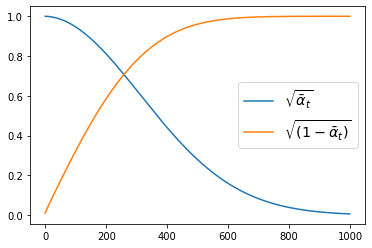

In [ ]:
noise_scheduler = DDPMScheduler(num_train_timesteps=1000)
plt.plot(noise_scheduler.alphas_cumprod.cpu() ** 0.5, label=r"${\sqrt{\bar{\alpha}_t}}$")
plt.plot((1 - noise_scheduler.alphas_cumprod.cpu()) ** 0.5, label=r"$\sqrt{(1 - \bar{\alpha}_t)}$")
plt.legend(fontsize="x-large");

In [ ]:
noise_scheduler.alphas_cumprod.cpu()[-1]

tensor(4.0358e-05)

In [ ]:
(1 - noise_scheduler.alphas_cumprod.cpu())[-1]

tensor(1.0000)

In [ ]:
noise_scheduler

DDPMScheduler {
  "_class_name": "DDPMScheduler",
  "_diffusers_version": "0.11.1",
  "beta_end": 0.02,
  "beta_schedule": "linear",
  "beta_start": 0.0001,
  "clip_sample": true,
  "num_train_timesteps": 1000,
  "prediction_type": "epsilon",
  "trained_betas": null,
  "variance_type": "fixed_small"
}

###Low Beta Start Low Beta End

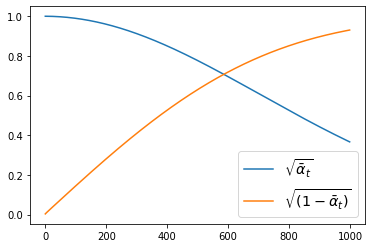

In [ ]:
noise_scheduler = DDPMScheduler(num_train_timesteps=1000, beta_start=0.00001, beta_end=0.004)
plt.plot(noise_scheduler.alphas_cumprod.cpu() ** 0.5, label=r"${\sqrt{\bar{\alpha}_t}}$")
plt.plot((1 - noise_scheduler.alphas_cumprod.cpu()) ** 0.5, label=r"$\sqrt{(1 - \bar{\alpha}_t)}$")
plt.legend(fontsize="x-large");

###High Beta Start High Beta End

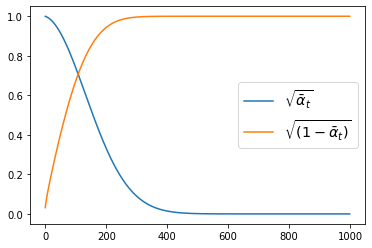

In [ ]:
noise_scheduler = DDPMScheduler(num_train_timesteps=1000, beta_start=0.001, beta_end=0.1)
plt.plot(noise_scheduler.alphas_cumprod.cpu() ** 0.5, label=r"${\sqrt{\bar{\alpha}_t}}$")
plt.plot((1 - noise_scheduler.alphas_cumprod.cpu()) ** 0.5, label=r"$\sqrt{(1 - \bar{\alpha}_t)}$")
plt.legend(fontsize="x-large");


In [ ]:
noise_scheduler.alphas_cumprod.cpu()[-1],(1 - noise_scheduler.alphas_cumprod.cpu())[-1]

(tensor(1.9847e-23), tensor(1.))

###Cosine (for smaller images)

Slow decrease of input image and slow increase of noise

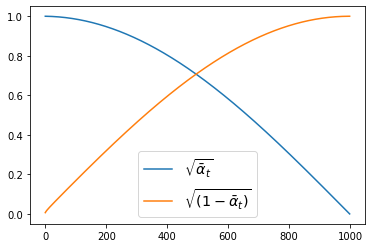

In [ ]:
# The 'cosine' schedule, which may be better for small image sizes:
noise_scheduler = DDPMScheduler(num_train_timesteps=1000, beta_schedule='squaredcos_cap_v2')
plt.plot(noise_scheduler.alphas_cumprod.cpu() ** 0.5, label=r"${\sqrt{\bar{\alpha}_t}}$")
plt.plot((1 - noise_scheduler.alphas_cumprod.cpu()) ** 0.5, label=r"$\sqrt{(1 - \bar{\alpha}_t)}$")
plt.legend(fontsize="x-large");

In [ ]:
noise_scheduler.alphas_cumprod.cpu()[-1],(1 - noise_scheduler.alphas_cumprod.cpu())[-1]

(tensor(2.4287e-09), tensor(1.))

###Observe

In [ ]:
timesteps = torch.linspace(0, 999, 8).long().to(device)
noise = torch.randn_like(x)
print("Noise", noise.shape)
noisy_x = noise_scheduler.add_noise(x, noise, timesteps)
print("Noisy X shape", noisy_x.shape)

Noise torch.Size([8, 3, 128, 128])
Noisy X shape torch.Size([8, 3, 128, 128])


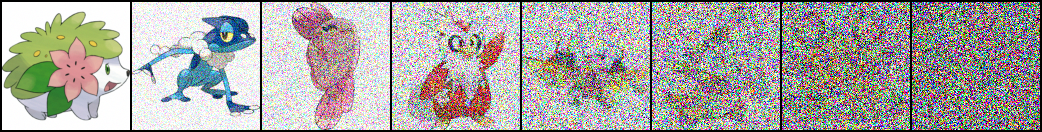

In [ ]:
show_images(noisy_x)

#Model

When dealing with higher-resolution inputs you may want to use more down and up-blocks, and keep the attention layers only at the lowest resolution (bottom) layers to reduce memory usage. We'll talk later about how you might experiment to find the best settings for your use-case.

In [ ]:
# Create a model
model = UNet2DModel(
    sample_size=image_size,  # the target image resolution
    in_channels=3,  # the number of input channels, 3 for RGB images
    out_channels=3,  # the number of output channels
    layers_per_block=2,  # how many ResNet layers to use per UNet block
    #defaults to — obj:(224, 448, 672, 896)
    block_out_channels=(64, 128, 128, 256),  # More channels -> more parameters
    down_block_types=(
        "DownBlock2D",  # a regular ResNet downsampling block
        "DownBlock2D",
        "AttnDownBlock2D",  # a ResNet downsampling block with spatial self-attention
        "AttnDownBlock2D",
    ),
    up_block_types=(
        "AttnUpBlock2D",
        "AttnUpBlock2D",  # a ResNet upsampling block with spatial self-attention
        "UpBlock2D",
        "UpBlock2D",  # a regular ResNet upsampling block
    ),
)
model.to(device);

In [ ]:
with torch.no_grad():
    model_prediction = model(noisy_x, timesteps).sample
model_prediction.shape

torch.Size([8, 3, 128, 128])

#Train

In [ ]:
# Set the noise scheduler
noise_scheduler = DDPMScheduler(
    num_train_timesteps=1000
)

# Training loop
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)

losses = []

for epoch in range(30):
    for step, batch in enumerate(train_dataloader):
        clean_images = batch["images"].to(device)

        # Sample noise to add to the images
        noise = torch.randn(clean_images.shape).to(clean_images.device)
        batch_size = clean_images.shape[0]

        # Sample a random timestep for each image
        #Choose a timesetp between 0 and num_timesteps for each image in batch
        timesteps = torch.randint(0, noise_scheduler.num_train_timesteps,
                                  (batch_size,), device=clean_images.device
        ).long()

        # Add noise to the clean images according to the noise magnitude at each timestep
        noisy_images = noise_scheduler.add_noise(clean_images, noise, timesteps)

        # Get the model prediction
        noise_pred = model(noisy_images, timesteps, return_dict=False)[0]

        # Calculate the loss
        loss = F.mse_loss(noise_pred, noise)
        loss.backward(loss)
        losses.append(loss.item())

        # Update the model parameters with the optimizer
        optimizer.step()
        optimizer.zero_grad()

    if (epoch + 1) % 5 == 0:
        loss_last_epoch = sum(losses[-len(train_dataloader) :]) / len(train_dataloader)
        print(f"Epoch:{epoch+1}, loss: {loss_last_epoch}")

Epoch:5, loss: 0.11296450729881014
Epoch:10, loss: 0.08008084432000205
Epoch:15, loss: 0.0677974049888906
Epoch:20, loss: 0.05570973026610556
Epoch:25, loss: 0.05334230074215503
Epoch:30, loss: 0.05432342225242229


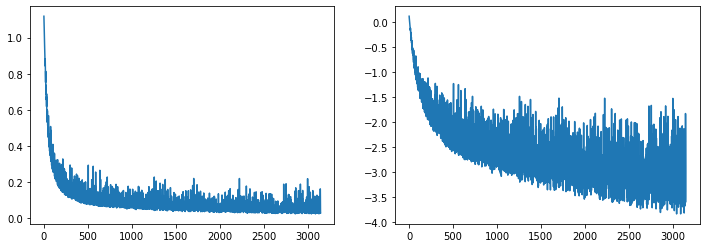

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
axs[0].plot(losses)
axs[1].plot(np.log(losses))
plt.show()

#Generate Images

In [ ]:
image_pipe = DDPMPipeline(unet=model, scheduler=noise_scheduler)

  0%|          | 0/1000 [00:00<?, ?it/s]

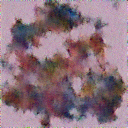

In [ ]:
pipeline_output = image_pipe()
pipeline_output.images[0]

In [ ]:
image_pipe.save_pretrained("my_pipeline")

##Without the pipeline

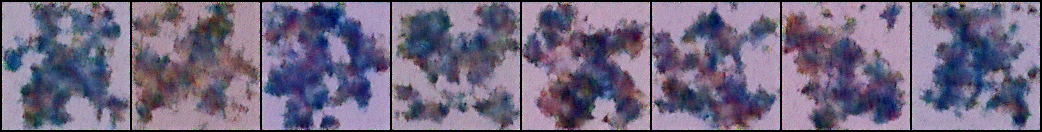

In [ ]:
# Random starting point (8 random images):
sample = torch.randn(8, 3, image_size, image_size).to(device)

for i, t in enumerate(noise_scheduler.timesteps):

    # Get model pred
    with torch.no_grad():
        residual = model(sample, t).sample

    # Update sample with step
    sample = noise_scheduler.step(residual, t, sample).prev_sample

show_images(sample)

#Push Pipeline

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

In [ ]:
%%capture
!sudo apt -qq install git-lfs
!git config --global credential.helper store

In [ ]:
from huggingface_hub import get_full_repo_name

model_name = "ddpm-pokemon-128"
hub_model_id = get_full_repo_name(model_name)
hub_model_id

In [ ]:
from huggingface_hub import HfApi, create_repo

create_repo(hub_model_id)
api = HfApi()
api.upload_folder(
    folder_path="my_pipeline/scheduler", path_in_repo="", repo_id=hub_model_id
)
api.upload_folder(folder_path="my_pipeline/unet", path_in_repo="", repo_id=hub_model_id)
api.upload_file(
    path_or_fileobj="my_pipeline/model_index.json",
    path_in_repo="model_index.json",
    repo_id=hub_model_id,
)

In [ ]:
from huggingface_hub import ModelCard

content = f"""
---
license: mit
tags:
- pytorch
- diffusers
- unconditional-image-generation
- diffusion-models-class
---

# Model Card based on Unit 1 of the [Diffusion Models Class 🧨](https://github.com/huggingface/diffusion-models-class)

This model is a diffusion model for unconditional image generation of Pokemon (size 128 X 128).
The model was trained on images from [this dataset](https://huggingface.co/datasets/lambdalabs/pokemon-blip-captions)

## Usage

```python
from diffusers import DDPMPipeline

pipeline = DDPMPipeline.from_pretrained('{hub_model_id}')
image = pipeline().images[0]
image
```
"""

card = ModelCard(content)
card.push_to_hub(hub_model_id)

In [ ]:
from diffusers import DDPMPipeline

image_pipe = DDPMPipeline.from_pretrained(hub_model_id)
pipeline_output = image_pipe()
pipeline_output.images[0]

#Scale up with Accelerate

In [ ]:
!wget https://github.com/huggingface/diffusers/raw/main/examples/unconditional_image_generation/train_unconditional.py

In [ ]:
# Let's give our new model a name for the Hub
model_name = "ddpm-pokemon-64-mp"
hub_model_id = get_full_repo_name(model_name)
hub_model_id

In [ ]:
!accelerate launch train_unconditional.py \
  --dataset_name="lambdalabs/pokemon-blip-captions" \
  --resolution=64 \
  --output_dir={model_name} \
  --train_batch_size=8 \
  --num_epochs=20 \
  --gradient_accumulation_steps=2 \
  --learning_rate=2e-4 \
  --lr_warmup_steps=500 \
  --mixed_precision="fp16"

In [ ]:
create_repo(hub_model_id)
api = HfApi()
api.upload_folder(
    folder_path=f"{model_name}/scheduler", path_in_repo="", repo_id=hub_model_id
)
api.upload_folder(
    folder_path=f"{model_name}/unet", path_in_repo="", repo_id=hub_model_id
)
api.upload_file(
    path_or_fileobj=f"{model_name}/model_index.json",
    path_in_repo="model_index.json",
    repo_id=hub_model_id,
)

content = f"""
---
license: mit
tags:
- pytorch
- diffusers
- unconditional-image-generation
- diffusion-models-class
---

# Model Card based on Unit 1 of the [Diffusion Models Class 🧨](https://github.com/huggingface/diffusion-models-class)

This model is a diffusion model for unconditional image generation of Pokemon (size 64 X 64).
The model was trained on images from [this dataset](https://huggingface.co/datasets/lambdalabs/pokemon-blip-captions) using fp16 training.

## Usage

```python
from diffusers import DDPMPipeline

pipeline = DDPMPipeline.from_pretrained('{hub_model_id}')
image = pipeline().images[0]
image
```
"""

card = ModelCard(content)
card.push_to_hub(hub_model_id)

In [ ]:
pipeline = DDPMPipeline.from_pretrained(hub_model_id).to(device)
images = pipeline(batch_size=8).images
make_grid(images)